# Verifying SUMO Traffic Light States

In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last"
import os
import sys
import pandas as pd
import numpy as np
import datetime
import pathlib
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sys.path.append(os.path.split(pathlib.Path().absolute())[0])

from sumo_function_library.SQL.rw_traffic_data import RWTrafficData
import sumo_function_library.functions.post_processing.helper_funcs as post_processing
from sumo_function_library.functions.intersection_parameters import IntersectionParameters
import definitions as var_def
from global_config_parameters import CONFIG
global_params = CONFIG()

## Enter the SUMO traffic light output file

In [2]:
DATA_FOLDER = '2020-02-13'
DATA_DIR = r'Z:\6 ACTION Project\SUMO\Sim_Output_Data\7-14-2020'
# DATA_DIR_FULL_PATH = os.path.join(definitions.DATA_DIR, DATA_FOLDER)
DATA_DIR_FULL_PATH = os.path.join(DATA_DIR, DATA_FOLDER)
RAW_DATA_FILE = 'tls_state_OUTPUT_.xml'
tls_file_name = os.path.join(DATA_DIR_FULL_PATH, RAW_DATA_FILE)

## Enter the Traffic Light Phasing File Location

In [3]:
tls_phasing = var_def.TRAFFIC_LIGHT_STATE_DESCRIPTION_ABSOLUTE

## Enter the Simulation Parameters

In [4]:
sim_start_time = '02/05/2020 06:00:00.000'

## Process SUMO traffic light output file

In [5]:
post_processing.convert_xml(
    sumo_detector_file=None,
    tls_file_name=tls_file_name,
)

_, sumo_tl_df = post_processing.read_csv(detect_csv_name=None)

tls_dict = {str(tl_id): None for tl_id in sumo_tl_df['tlLogic_id'].unique()}

drop_columns = ['tlLogic_type', 'phase_duration', 'tlLogic_programID', 'interval_end', 'interval_begin']

for tl_id in tls_dict.keys():
    
    # Make a copy of the tls dataframe with tl_id matching
    local_df = sumo_tl_df.loc[sumo_tl_df['tlLogic_id'] == int(tl_id)].copy()

    # Calulculate the cumulative sum of the phase end times. Gives simulation time
    local_df.loc[:, 'interval_end'] = local_df['phase_duration'].cumsum()

    # Calculate the begin time of the phases. (begin time = last phase end time)
    local_df.loc[:, 'interval_begin'] = [
        0 if i == 0 else local_df['interval_end'].values[i - 1]
        for i in range(len(local_df['interval_end'].values))
    ]
    
    # switch the begin and end times to pd.datetime. 
    local_df.loc[:, 'interval_begin_dt'] = local_df['interval_begin'].apply(
        lambda x: datetime.datetime.strptime(sim_start_time, '%m/%d/%Y %H:%M:%S.%f'
                                             ) + datetime.timedelta(seconds=x))
    local_df.loc[:, 'interval_end_dt'] = local_df['interval_end'].apply(
        lambda x: datetime.datetime.strptime(sim_start_time, '%m/%d/%Y %H:%M:%S.%f'
                                             ) + datetime.timedelta(seconds=x))
    
    local_df.set_index(local_df.loc[:, 'interval_begin_dt'], inplace=True)
    
    local_df.drop(labels=drop_columns, axis=1, inplace=True)
    
    tls_dict[tl_id] = local_df

## Processing the SUMO TL Phasing

In [6]:
tls_phasing_df = pd.read_excel(tls_phasing)
tls_phasing_dict = {tl_id: [int(num) for num in tls_phasing_df.loc[tls_phasing_df['traffic_light_id'] == tl_id]['key']
                    .values.tolist()[0].split(',')]
                    for tl_id in tls_phasing_df['traffic_light_id'].values}

In [7]:
tls_phasing_dict

{63069006: [6, 6, 6, 6, 1, 8, 3, 2, 2, 2, 2, 5, 4, 7],
 63069007: [6, 6, 6, 6, 1, 1, 4, 4, 2, 2, 5, 3, 3, 3],
 63069008: [6, 6, 6, 6, 1, 4, 7, 2, 2, 2, 2, 5, 8, 8, 3],
 63069009: [6, 6, 6, 2, 2, 5, 4, 4]}

## Getting the SUMO Traffic Light State from Phase

In [8]:
def phase_infer(row):
    
    phase_state = row['phase_state']
    tl_id = row['tlLogic_id']
    
    green_list = []
    yellow_list = []
    for i, letter in enumerate(phase_state):
        if letter == 'G':
            green_list.append(tls_phasing_dict[tl_id][i])
        if letter == 'y':
            yellow_list.append(tls_phasing_dict[tl_id][i])

    unique_green = list(set(green_list))
    unique_yellow = list(set(yellow_list))
    
    return [unique_green, unique_yellow]

In [9]:
for tl_id in tls_dict.keys():
    phase_stack = tls_dict[tl_id].apply(phase_infer, axis=1)
    tls_dict[tl_id]['green'] = [x[0] for x in phase_stack.values]
    tls_dict[tl_id]['yellow'] = [x[1] for x in phase_stack.values]


## Enter the RW SQL Data File

In [149]:
rw_file_name = os.path.join(var_def.SQL_DATA_DIR_ABSOLUTE, '2020-02-05.csv')

## Process the RW Data File

In [150]:
light_event_dict = RWTrafficData(rw_file_name).active_phase_events.get_light_events(traffic_light_ids=None)

## Reworking the RW Data into the dictionary format

In [151]:
rw_tl_dict = {tl_id: {} for tl_id in light_event_dict.keys()}
for tl_id in light_event_dict.keys():
    rw_tl_dict[tl_id]['green'] = light_event_dict[tl_id][0].to_frame()
    rw_tl_dict[tl_id]['yellow'] = light_event_dict[tl_id][1].to_frame()
    rw_tl_dict[tl_id]['red'] = light_event_dict[tl_id][2].to_frame()

## Handling the RW Data Format

The TL Controllers only report the change since the last state, not the current phase. Must look backwards to determine if (for example) 2 & 5 and not just 2

In [152]:
for tl_id in rw_tl_dict.keys():
    
    for state in rw_tl_dict[tl_id].keys():
        
        rw_tl_dict[tl_id][state]['phase_1'] = ''
        rw_tl_dict[tl_id][state]['phase_2'] = ''
        
        for i in range(len(rw_tl_dict[tl_id][state].index)):
            
            rw_tl_dict[tl_id][state]['EventParam'][i] = [int(phase) for phase 
                                                         in rw_tl_dict[tl_id][state]['EventParam'][i]]
            
            if i != 0 and i < len(rw_tl_dict[tl_id][state].index)-1:
                 
                
                if (len(rw_tl_dict[tl_id][state]['EventParam'].iloc[i]) < 2) and (state == 'green'):
                    
                    # Checking the time length until the next phase (sometimes the greens are not served at the same time)
                    next_change_interval = (rw_tl_dict[tl_id][state].index[i+1] - rw_tl_dict[tl_id][state].index[i]).seconds 
                    
                    if (state != 'green') or (next_change_interval > 3):
                        
                        # Only get the previous state if an immediate change is not coming.
                        new = ["",""]
                        current = rw_tl_dict[tl_id][state]['EventParam'].iloc[i][0]
                        last = rw_tl_dict[tl_id][state]['EventParam'].iloc[i-1]

                        if current < 5:
                            new[0] = current
                            for last_phase in last:
                                if (last_phase >= 5 and last_phase <= 6) and new[0] <= 2:
                                    new[1] = last_phase
                                    break
                                elif (last_phase > 6 and last_phase <= 8) and new[0] > 2:
                                    new[1] = last_phase
                                    break
                        else:
                            new[1] = current
                            for last_phase in last:
                                if (last_phase > 0 and last_phase <= 2) and new[1] <= 6:
                                    new[0] = last_phase
                                    break
                                elif (last_phase > 2 and last_phase <= 4) and new[1] > 6:
                                    new[0] = last_phase
                                    break

                        new_new = []
                        x = [new_new.append(x) if isinstance(x, int) else None for x in new]
                        rw_tl_dict[tl_id][state]['EventParam'].iloc[i] = new_new.copy()
                        
                    else:
                        print("Exception {tl_id}, {state}, {time}".format(tl_id=tl_id, 
                                                                          state=state, time=rw_tl_dict[tl_id][state].index[i]))

            for phase in rw_tl_dict[tl_id][state]['EventParam'].iloc[i]:
                j = [1 if phase < 5 else 2][0]
                rw_tl_dict[tl_id][state].loc[:,'phase_'+str(j)].iloc[i] = phase

Exception 63069006, green, 2020-02-05 07:29:23.900000
Exception 63069008, green, 2020-02-05 07:05:28.700000
Exception 63069008, green, 2020-02-05 07:26:05.700000
Exception 63069008, green, 2020-02-05 07:35:33
Exception 63069008, green, 2020-02-05 07:56:43
Exception 63069008, green, 2020-02-05 07:59:07.700000
Exception 63069008, green, 2020-02-05 07:59:49.500000


In [154]:
rw_tl_dict['63069006']['yellow'].tail(20)
#rw_tl_dict['63069006']['yellow'].resample('0.1S').asfreq()
#rw_tl_dict['63069006']['green'].resample('0.1S').asfreq()

# phased_dict = {'green': {}, 'yellow': {}}
# phased_dict['green'] = {tl_id: {phase: None for phase in range(1, 8)} for tl_id in rw_tl_dict.keys()}
# phased_dict['yellow'] = phased_dict['green'].copy()


next_state_dict = {'green': 'yellow', 'yellow': 'red', 'red':'green'}

for tl_id in rw_tl_dict.keys():
    for state in rw_tl_dict[tl_id].keys(): 
#         rw_tl_dict[tl_id][state] = rw_tl_dict[tl_id][state].to_frame()
        rw_tl_dict[tl_id][state]['phase_1_off_time'] = ''
        rw_tl_dict[tl_id][state]['phase_2_off_time'] = ''

        print(tl_id)

        for i in range(len(rw_tl_dict[tl_id][state].index)):

            try:
                for j in range(1, 3):

                    green_on_time = rw_tl_dict[tl_id][state].index[i]

                    phase =  rw_tl_dict[tl_id][state]['phase_' + str(j)].iloc[i]
                    
                    next_state = next_state_dict[state]

                    if phase != "":
                        
                        if state != 'red':

                            next_time = rw_tl_dict[tl_id][next_state].loc[(rw_tl_dict[tl_id][next_state].index 
                                                        > green_on_time)  & 
                                                     (rw_tl_dict[tl_id][next_state].loc[:, 'phase_' + str(j)] == phase)].index[0]
                        else:
                            
                            next_time = rw_tl_dict[tl_id][next_state].loc[(rw_tl_dict[tl_id][next_state].index 
                                                        > green_on_time)].index[0]
                            
                        rw_tl_dict[tl_id][state]['phase_' + str(j) + '_off_time'].iloc[i] = pd.to_datetime(next_time)
                        #rw_tl_dict[tl_id]['green']['yellow_phase'].iloc[i] = rw_tl_dict[tl_id]['yellow'].loc[yellow_on_time, 'EventParam']

            except IndexError:
                break


63069006
63069006
63069006
63069009
63069009
63069009
63069007
63069007
63069007
63069008
63069008
63069008


In [147]:
display_html(combined_styler._repr_html_(), raw=True)

,EventParam,State
Timestamp,,
2020-02-05 06:05:24.300000,"[2, 6]",Y
2020-02-05 06:05:29.700000,"[2, 6]",R
2020-02-05 06:05:30.700000,[3],G
2020-02-05 06:05:38.400000,[3],Y
2020-02-05 06:05:41.400000,[3],R
2020-02-05 06:05:43.900000,[4],G
2020-02-05 06:06:00.500000,[4],Y
2020-02-05 06:06:04.100000,[4],R
2020-02-05 06:06:05.800000,"[2, 5]",G


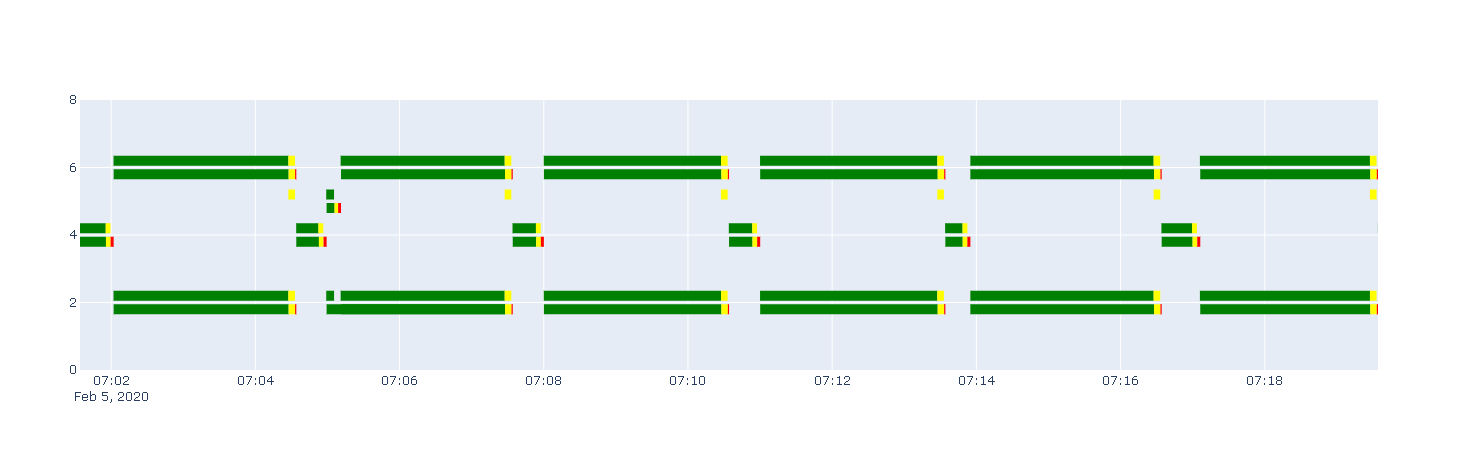

In [157]:
tl_id = '63069009'

lower_time = '02/05/2020 07:00:00.000'
upper_time = '02/05/2020 07:20:00.000'

upper_time_dt = datetime.datetime.strptime(upper_time, '%m/%d/%Y %H:%M:%S.%f')
lower_time_dt = datetime.datetime.strptime(lower_time, '%m/%d/%Y %H:%M:%S.%f')
#tls_dict[tl_id].loc[(tls_dict[tl_id]['interval_begin_dt'] > lower_time_dt) and (tls_dict[tl_id]['interval_begin_dt'] <= upper_time_dt)]

plot_sumo_df = tls_dict[tl_id].loc[(tls_dict[tl_id]['interval_begin_dt'] > lower_time_dt) & 
                                   (tls_dict[tl_id]['interval_begin_dt'] < upper_time_dt)] 

plot_rw_dict = {}


state_settings = {'green': {'color': 'green'},
                 'yellow': {'color': 'yellow'},
                 'red': {'color': 'red'}
                 }

width = 10

plot_rw_dict['green'] = rw_tl_dict[tl_id]['green'].loc[(rw_tl_dict[tl_id]['green'].index > lower_time_dt) & 
                                   (rw_tl_dict[tl_id]['green'].index < upper_time_dt)]

plot_rw_dict['yellow'] = rw_tl_dict[tl_id]['yellow'].loc[(rw_tl_dict[tl_id]['yellow'].index > lower_time_dt) & 
                                   (rw_tl_dict[tl_id]['yellow'].index < upper_time_dt)]

plot_rw_dict['red'] = rw_tl_dict[tl_id]['red'].loc[(rw_tl_dict[tl_id]['red'].index > lower_time_dt) & 
                                   (rw_tl_dict[tl_id]['red'].index < upper_time_dt)]


fig = go.Figure()
fig.add_trace(go.Scatter(x=[plot_rw_dict['green'].index[0], plot_rw_dict['green'].index[-1]], opacity=0))

fig.update_xaxes(range=[plot_rw_dict['green'].index[0], plot_rw_dict['green'].index[-1]])
fig.update_yaxes(range=[0, 8])

offset = 0.2

for i in range(len(plot_sumo_df.index)):
    for j in range(len(plot_sumo_df['green'].iloc[i])): # deals with the 1 or 2 phases
        fig.add_shape(
                # Line Horizontal
                dict(
                    type="line",
                    x0=plot_sumo_df['interval_begin_dt'].iloc[i],
                    y0=plot_sumo_df['green'].iloc[i][j] + offset,
                    x1=plot_sumo_df['interval_end_dt'].iloc[i],
                    y1=plot_sumo_df['green'].iloc[i][j] + offset,
                    line=dict(
                        color="Green",
                        width=width
                    )
        )
        )
        
    for j in range(len(plot_sumo_df['yellow'].iloc[i])): 
        fig.add_shape(
                # Line Horizontal
                dict(
                    type="line",
                    x0=plot_sumo_df['interval_begin_dt'].iloc[i],
                    y0=plot_sumo_df['yellow'].iloc[i][j] + offset,
                    x1=plot_sumo_df['interval_end_dt'].iloc[i],
                    y1=plot_sumo_df['yellow'].iloc[i][j] + offset,
                    line=dict(
                        color="yellow",
                        width=width
                    )
                )
        )

for state in plot_rw_dict.keys():
    
    for i in range(len(plot_rw_dict[state].index)):
        
        for j in range(1,3):
            
            if plot_rw_dict[state]['phase_' + str(j)].iloc[i] != "":
                
                phase = plot_rw_dict[state]['phase_' + str(j)].iloc[i]
                end_time = plot_rw_dict[state]['phase_' + str(j) + '_off_time'].iloc[i]
                
                fig.add_shape(
                    dict(
                        type="line",
                        x0=plot_rw_dict[state].index[i],
                        y0=phase - offset,
                        x1=end_time,
                        y1=phase - offset,
                        line=dict(
                            color=state_settings[state]['color'],
                            width=width
                        )
                    )
                )
                   
fig.update_layout({'hovermode': 'closest', 'xaxis': {'showspikes': True}
    })
    
fig.update_shapes(dict(xref='x', yref='y'))
fig.show()



In [155]:
from IPython.display import display_html 

#light_event_dict[tl_id][1].head(50)

# df1_styler = light_event_dict[tl_id][0].to_frame().style.set_table_attributes("style='display:inline'").set_caption('Green')
# df2_styler = light_event_dict[tl_id][1][1:].to_frame().style.set_table_attributes("style='display:inline'").set_caption('Yellow')
# df3_styler = light_event_dict[tl_id][2][1:].to_frame().style.set_table_attributes("style='display:inline'").set_caption('Red')

# display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_(), raw=True)


tl_id = '63069007'

green_df = light_event_dict[tl_id][0].to_frame()
green_df['State'] = 'G'
yellow_df = light_event_dict[tl_id][1].to_frame()
yellow_df['State'] = 'Y'
red_df = light_event_dict[tl_id][2].to_frame()
red_df['State'] = 'R'

combined_df = green_df.append(yellow_df, sort=True)
combined_df = combined_df.append(red_df, sort=True)
combined_df.sort_index(inplace=True)

combined_styler = combined_df.style.set_table_attributes("style='display:inline'")

#display_html(combined_styler)

ind_styler = rw_tl_dict['63069007']['yellow'].style.set_table_attributes("style='display:inline'")

display_html(ind_styler._repr_html_(), raw=True)

,EventParam,phase_1,phase_2,phase_1_off_time,phase_2_off_time
Timestamp,,,,,
2020-02-05 06:05:24.300000,"[2, 6]",2,6,2020-02-05 06:05:29.700000,2020-02-05 06:05:29.700000
2020-02-05 06:05:38.400000,[3],3,,2020-02-05 06:05:41.400000,
2020-02-05 06:06:00.500000,[4],4,,2020-02-05 06:06:04.100000,
2020-02-05 06:06:11.600000,[5],,5,,2020-02-05 06:06:14.600000
2020-02-05 06:07:40.100000,[2],2,,2020-02-05 06:07:45.500000,
2020-02-05 06:08:10,"[1, 6]",1,6,2020-02-05 06:08:13,2020-02-05 06:08:15.400000
2020-02-05 06:08:26.300000,[3],3,,2020-02-05 06:08:29.300000,
2020-02-05 06:08:38.800000,[4],4,,2020-02-05 06:08:42.400000,
2020-02-05 06:10:40.100000,[2],2,,2020-02-05 06:10:45.500000,
